In [1]:
# To have each Python cell auto-formatted
# See: https://black.readthedocs.io
%load_ext lab_black

# Training MNIST with PyTorch

## Introduction
Recognizing handwritten digits based on the [MNIST (Modified National Institute of Standards and Technology) data set](http://yann.lecun.com/exdb/mnist/) is the "Hello, World" example of machine learning.
Each (anti-aliased) black-and-white image represents a digit from 0 to 9 and has been fit into a 28x28 pixel bounding box.
The problem of recognizing digits from handwriting is, for instance, important to the postal service when automatically reading zip codes from envelopes.

### What You'll Learn
We'll show you how to use PyTorch to build a model with two convolutional layers and two fully connected layers to perform the multi-class classification of images provided.
In addition, there is a dropout layer after the convolutional layers (and before the first fully connected layer) and another one right after the very first fully connected layer.
An approach using the `Sequential` module is available [here](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html).

The example in the notebook includes both training a model in the notebook and running a [distributed](https://pytorch.org/tutorials/intermediate/dist_tuto.html) `PyTorchJob` on the cluster, so you can easily scale up your own models.
For the distributed training job you'll need to package the complete trainer code in a Docker image.
We'll show you how to do that with Kubeflow Fairing, so that you do not have to leave your favourite notebook environment at all!
We'll also include instructions for local development, in case you prefer that.

<div class="alert alert-block alert-info">
<b>Kubernetes Nomenclature</b><br>
    <code>PyTorchJob</code> is a <a href="https://kubernetes.io/docs/concepts/extend-kubernetes/api-extension/custom-resources/">custom resource (definition) (CRD)</a> provided by the <a href="https://www.kubeflow.org/docs/reference/pytorchjob/v1/pytorch/">PyTorch operator</a>.
    <a href="https://kubernetes.io/docs/concepts/extend-kubernetes/operator/">Operators</a> extend Kubernetes by capturing domain-specific knowledge on how to deploy and run an application or service, how to deal with failures, and so on.
    The lifecycle of a <code>PyTorchJob</code> is managed by the of the PyTorch operator controller.
</div>


### What You'll Need
All you need is this notebook.
If you prefer to create your Docker image locally, you must also have a Docker client installed on your machine.

## Prerequisites
Before we proceed, let's check that we're using the right image, that is, [PyTorch](https://pytorch.org/docs/stable/torch.html) is available:

In [2]:
! pip list | grep torch

kubeflow-pytorchjob      0.1.3              
torch                    1.5.0              
torchvision              0.6.0a0+82fd1c8    


To package the trainer in a container image, we shall need a file (on our cluster) that contains the code as well as a file with the resource definitition of the job for the Kubernetes cluster:

In [3]:
TRAINER_FILE = "mnist.py"
KUBERNETES_FILE = "pytorchjob-mnist.yaml"

We also want to capture output from a cell with [`%%capture`](https://ipython.readthedocs.io/en/stable/interactive/magics.html#cellmagic-capture) that usually looks like `some-resource created`.
To that end, let's define a helper function:

In [4]:
import re

from IPython.utils.capture import CapturedIO


def get_resource(captured_io: CapturedIO) -> str:
    """
    Gets a resource name from `kubectl apply -f <configuration.yaml>`.

    :param str captured_io: Output captured by using `%%capture` cell magic
    :return: Name of the Kubernetes resource
    :rtype: str
    :raises Exception: if the resource could not be created
    """
    out = captured_io.stdout
    matches = re.search(r"^(.+)\s+created", out)
    if matches is not None:
        return matches.group(1)
    else:
        raise Exception(
            f"Cannot get resource as its creation failed: {out}. It may already exist."
        )

## How to Load and Inspect the Data
Before we train our model, it is sensible to inspect the data we are about to feed it.

In [2]:
from torchvision import datasets, transforms

# See: https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.MNIST
mnist = datasets.MNIST("datasets", download=False, train=True, transform=transforms.ToTensor())
mnist

Dataset MNIST
    Number of datapoints: 60000
    Root location: datasets
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
list(mnist.data.size())

[60000, 28, 28]

We are therefore dealing with 60,000 28x28 pixel greyscale images.
These have not yet been scaled into the [0, 1] range, as we can see:

In [7]:
mnist.data.float().min(), mnist.data.float().max()

(tensor(0.), tensor(255.))

In [8]:
# See: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class
example, example_label = mnist.__getitem__(42)

In [9]:
import numpy as np

from matplotlib import pyplot as plt

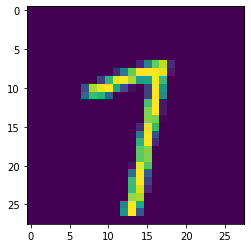

In [10]:
%matplotlib inline
plt.imshow(np.squeeze(example))
plt.show()

The corresponding label is:

In [11]:
example_label

7

We shall normalize the data set (to improve the training speed), which means we need to know the mean and standard deviation:

In [12]:
mnist.data.float().mean() / 255, mnist.data.float().std() / 255

(tensor(0.1307), tensor(0.3081))

These are the values we shall hard-code in our transformations within the model.
Ideally, we re-compute these based on the training data set to ensure we capture the correct values when the underlying data changes.
Our data set is static, though.
Note that these values are _always_ re-used (i.e. not re-computed) when predicting (or serving) to minimize training/serving skew.
For our demonstration it is fine to define these up front.
Batch normalization would be an alternative that scales better with data sets of any size.

<div class="alert alert-block alert-info">
<b>A Note on Batch Normalization</b><br>
    <a href="https://arxiv.org/abs/1502.03167">Batch normalization</a> computes the mean and variance per batch of training data and per layer to rescale the batch's input values with the aid of two hyperparameters: β (shift) and γ (scale).
    It is typically applied before the activation function (as in the original paper), although there is <a href="https://blog.paperspace.com/busting-the-myths-about-batch-normalization/">no concensus</a> on the matter and there may be valid reasons to apply it afterwards.
    Batch normalization allows weights in later layers to be more robust against changes in input values of the earlier ones; while the input of later layers can obviously vary from step to step, the mean and variance will remain fairly constant.
    This is because we shuffle the training data set and each batch is therefore on average roughly representative of the entire data set.
    Batch normalization limits the distribution of weight values in the later layers of a neural network, and therefore provides a regularizing effect that decreases as the batch size increases.<br><br>
    At prediction time, batch normalization requires (fixed) values for the mean and variance to transform the data.
    The population statistics are the obvious choice, computed across batches from either moving averages or the exponentially weighted averages.
    It is often argued that we use these rather the equivalent values at inference time, because we may not receive batches to predict on; we cannot compute the mean and variance sensibly for individual examples.
    While that is certainly true in some cases (e.g. online predictions), the main reason is to avoid training/serving skew.
    Even with batches at inference, there may be significant correlation present (e.g. data from the same entity, such as a user, a session, a region, a product, a machine or assembly line, and so on).
    In these cases, the mean/variance of the prediction batch may not be representative of the population at large.
    Once scaled, these input values may well be near the population mean of zero with unit variance, even though in the overall population they would have been near the tails of the distribution.
</div>

In [13]:
# Clear variables as we have no need for these any longer
del mnist, example, example_label

<div class="alert alert-block alert-info">
    Before we proceed, we separate the <code>epoch</code> hyperparameter from the main code.
    The reason we do that is to ensure we can run the notebook in so-called headless mode with <a href="https://papermill.readthedocs.io/en/latest/">Papermill</a> for custom parameters.
    This allows us to test the notebooks end-to-end automatically.
    If you check the <a href="https://jupyterlab.readthedocs.io/en/stable/user/notebook.html#notebook">cell tag</a> of the next cell, you can see it is tagged as <code>parameters</code>.
    Feel free to ignore it!
</div>

In [14]:
epochs = 5

## How to Train the Model in the Notebook

Since we ultimately want to train the model in a distributed fashion (potentially on GPUs), we put all the code in a single cell.
That way we can save the file and include it in a container image:

In [15]:
%%writefile $TRAINER_FILE
import argparse
import logging
import os

import torch
import torch.distributed as dist
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms

logging.getLogger().setLevel(logging.INFO)

# Number of processes participating in (distributed) job
# See: https://pytorch.org/docs/stable/distributed.html
WORLD_SIZE = int(os.environ.get("WORLD_SIZE", 1))


# Custom models must subclass toch.nn.Module and override `forward`
# See: https://pytorch.org/docs/stable/nn.html#torch.nn.Module
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


def should_distribute():
    return dist.is_available() and WORLD_SIZE > 1


def is_distributed():
    return dist.is_available() and dist.is_initialized()


def percentage(value):
    return "{: 5.1f}%".format(100.0 * value)


def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            logging.info(
                f"Epoch: {epoch} ({percentage(batch_idx / len(train_loader))}) - Loss: {loss.item()}"
            )


def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(
                output, target, reduction="sum"
            ).item()  # sum batch losses
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    logging.info(
        f"Test accuracy: {correct}/{len(test_loader.dataset)} ({percentage(correct / len(test_loader.dataset))})"
    )

    # Log metrics for Katib
    logging.info("loss={:.4f}".format(test_loss))
    logging.info("accuracy={:.4f}".format(float(correct) / len(test_loader.dataset)))


def main():
    parser = argparse.ArgumentParser(description="PyTorch MNIST Training Job")
    parser.add_argument(
        "--batch-size",
        type=int,
        default=64,
        metavar="N",
        help="Batch size for training (default: 64)",
    )
    parser.add_argument(
        "--test-batch-size",
        type=int,
        default=1000,
        metavar="N",
        help="Batch size for testing (default: 1000)",
    )
    parser.add_argument(
        "--epochs",
        type=int,
        default=5,
        metavar="N",
        help="Number of epochs to train",
    )
    parser.add_argument(
        "--lr",
        type=float,
        default=1.0,
        metavar="LR",
        help="Learning rate (default: 1.0)",
    )
    parser.add_argument(
        "--gamma",
        type=float,
        default=0.7,
        metavar="M",
        help="Learning rate's decay rate (default: 0.7)",
    )
    parser.add_argument(
        "--no-cuda",
        action="store_true",
        default=False,
        help="Disables CUDA (GPU) training",
    )
    parser.add_argument(
        "--seed", type=int, default=1, metavar="S", help="Random seed (default: 1)"
    )
    parser.add_argument(
        "--log-interval",
        type=int,
        default=10,
        metavar="N",
        help="Number of training batches between status log entries",
    )
    parser.add_argument(
        "--save-model",
        action="store_true",
        default=False,
        help="Whether to save the trained model",
    )

    if dist.is_available():
        parser.add_argument(
            "--backend",
            type=str,
            help="Distributed backend",
            choices=[dist.Backend.GLOO, dist.Backend.NCCL, dist.Backend.MPI],
            default=dist.Backend.GLOO,
        )

    args, _ = parser.parse_known_args()
    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    if should_distribute():
        logging.debug("Using distributed PyTorch with {} backend".format(args.backend))
        dist.init_process_group(backend=args.backend)

    kwargs = {"num_workers": 1, "pin_memory": True} if use_cuda else {}
    train_data = datasets.MNIST(
        "datasets",
        download=False,
        train=True,
        transform=transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
        ),
    )

    # DistributedSampler partitions the training dataset among the worker processes
    train_sampler = (
        torch.utils.data.distributed.DistributedSampler(train_data)
        if should_distribute()
        else None
    )

    train_loader = torch.utils.data.DataLoader(
        train_data,
        batch_size=args.batch_size,
        sampler=train_sampler,
        shuffle=False,
        **kwargs,
    )

    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST(
            "datasets",
            download=False,
            train=False,
            transform=transforms.Compose(
                [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
            ),
        ),
        batch_size=args.test_batch_size,
        shuffle=True,
        **kwargs,
    )

    device = torch.device("cuda" if use_cuda else "cpu")
    model = Net().to(device)

    if is_distributed():
        if use_cuda:
            torch.cuda.set_device(torch.cuda.current_device())
        model = nn.parallel.DistributedDataParallel(model)

    # See: https://pytorch.org/docs/stable/optim.html#torch.optim.Adadelta
    optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

    # See: https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.StepLR
    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        test(args, model, device, test_loader)
        scheduler.step()

    if args.save_model:
        torch.save(model.state_dict(), "mnist_model.pt")


if __name__ == "__main__":
    main()

Writing mnist.py


That saves the file as defined by `TRAINER_FILE` but it does not run it.

The log entries for 'Katib' are to re-use the same file for [hyperparameter tuning](../../katib/Hyperparameter%20Tuning.ipynb), which is done in a separate notebook.
All you need to know for that is that Katib looks for `key=value` entries in the logs.

<div class="alert alert-block alert-info">
<b>A Note on Activation Functions</b><br>
    A common choice for <a href="https://arxiv.org/abs/1606.02228">activation functions</a> is a ReLU (Rectified Linear Unit).
    It is linear for non-negative values and zero for negative ones.
    The <a href="https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/">main benefits of ReLU</a> as opposed to sigmoidal functions (e.g. logistic or `tanh`) are:
    <ul>
        <li>ReLU and its gradient are very cheap to compute;</li>
        <li>Gradients are less likely to vanish, because for (non-)negative values its gradient is constant and therefore does not saturate, which for deep neural networks can <a href="https://dl.acm.org/doi/10.1145/3065386">accelerate convergence</a></li>
        <li>ReLU has a regularizing effect, because it promotes <a href="https://www.researchgate.net/publication/215616967_Deep_Sparse_Rectifier_Neural_Networks">sparse representations</a> (i.e. some nodes' weights are zero);</li>
        <li>Empirically it has been found to work well.</li>
    </ul>
    ReLU activation functions can cause neurons to 'die' because a large, negative (learned) bias value causes all inputs to be negative, which in turn leads to a zero output.
    The neuron has thus become incapable of discriminating different input values.
    So-called leaky ReLU activations functions address that issue; these functions are linear but non-zero for negative values, so that their gradients are small but non-zero.
    <a href="https://arxiv.org/abs/1511.07289">ELUs</a>, or exponential linear units, are another solution to the problem of dying neurons.
</div>

<div class="alert alert-block alert-info">
    <b>A Note on CNNs</b><br>
    While it is not our intention to cover the basics of <a href="https://www.deeplearningbook.org/contents/convnets.html">convolutional neural networks</a> (CNNs), there are a few matters worth mentioning.
    Convolutional layers are spatial feature extractors for images.
    A series of convolutional kernels (of the same dimensions) is applied to the image to obtain different versions of the same base image (i.e. filters).
    These filters extract patterns hierarchically.
    In the first layer, filters typically capture dots, edges, corners, and so on.
    With each additional layer, these patterns become more complex and turn from basic geometric shapes into constituents of objects and entire objects.
    That is why often the number of filters increases with each additional convolutional layer: to extract more complex patterns.<br><br>
    Convolutional layers are often followed by a pooling layer to down-sample the input.
    This aids in lowering the computational burden as we increase the number of filters.
    A max pooling layer simply picks the largest value of pixels in a small (rectangular) neighbourhood of a single channel (e.g. RGB).
    This has the effect of making features <em>locally</em> translation-invariant, which is often desired: whether a feature of interest is on the left or right edge of a pooling window, which is also referred to as a kernel, is largely irrelevant to the problem of image classification.
    Note that this may not always be a desired characteristic and depends on the size of the pooling kernel.
    For instance, the precice location of tissue damage in living organisms or defects on manufactured products may be very significant indeed.
    Pooling kernels are generally chosen to be relatively small compared to the dimensions of the input, which means that local translation invariance is often desired. <br><br>
    Another common component of CNNs is a dropout layer.
    <a href="http://jmlr.org/papers/v15/srivastava14a.html">Dropout</a> provides a mechanism for regularization that has proven successful in many applications.
    It is suprisingly simple: some nodes' weights (and biases) in a specific layer are set to zero <em>at random</em>, that is, arbitrary nodes are removed from the network during the training step.
    This causes the network to not rely on any single node (a.k.a. neuron) for a feature, as each node can be dropped at random.
    The network therefore has to learn redundant representations of features.
    This is important because of what is referred to as <em>internal covariate shift</em> (often mentioned in connection with <a href="http://proceedings.mlr.press/v37/ioffe15.html">batch normalization</a>): the change of distributions of internal nodes' weights due to all other layers, which can cause nodes to stop learning (i.e. updating their weights).
    Thanks to dropout, layers become more robust to changes, although it also means it limits what can be learnt (as always with regularization).
    Still, dropout is the neural network's equivalent of the saying you should never put all your eggs in one basket.
    Layers with a high risk of overfitting (e.g. layers with many units and lots of inputs) typically have a higher dropout rate.
    <br><br>
    A nice visual explanation of convolutional layers is available <a href="https://cezannec.github.io/Convolutional_Neural_Networks/">here</a>.
    If you're curious what a CNN "sees" while training, you can have a look <a href="https://poloclub.github.io/cnn-explainer/">here</a>.
</div>

Let's see if our code is correct by running it from within our notebook:

In [16]:
%run $TRAINER_FILE --epochs $epochs --log-interval 128

INFO:root:Epoch: 1 (  0.0%) - Loss: 2.293032646179199
INFO:root:Epoch: 1 ( 13.6%) - Loss: 0.5257666110992432
INFO:root:Epoch: 1 ( 27.3%) - Loss: 0.08510863780975342
INFO:root:Epoch: 1 ( 40.9%) - Loss: 0.32805368304252625
INFO:root:Epoch: 1 ( 54.6%) - Loss: 0.3279671370983124
INFO:root:Epoch: 1 ( 68.2%) - Loss: 0.06365685909986496
INFO:root:Epoch: 1 ( 81.9%) - Loss: 0.29687821865081787
INFO:root:Epoch: 1 ( 95.5%) - Loss: 0.03434577211737633
INFO:root:Test accuracy: 9834/10000 ( 98.3%)
INFO:root:loss=0.0500
INFO:root:accuracy=0.9834
INFO:root:Epoch: 2 (  0.0%) - Loss: 0.08447802066802979
INFO:root:Epoch: 2 ( 13.6%) - Loss: 0.2620002329349518
INFO:root:Epoch: 2 ( 27.3%) - Loss: 0.10486980527639389
INFO:root:Epoch: 2 ( 40.9%) - Loss: 0.07522107660770416
INFO:root:Epoch: 2 ( 54.6%) - Loss: 0.044803790748119354
INFO:root:Epoch: 2 ( 68.2%) - Loss: 0.06450511515140533
INFO:root:Epoch: 2 ( 81.9%) - Loss: 0.25487586855888367
INFO:root:Epoch: 2 ( 95.5%) - Loss: 0.01875779777765274
INFO:root:Test 

<Figure size 432x288 with 0 Axes>

This trains the model in the notebook, but does not distribute it across nodes (a.k.a. pods) in our cluster.
To that end, we have to first create a Docker image with the code, push it to a registry (e.g. [Docker Hub](https://hub.docker.com/), [Azure Container Registry](https://azure.microsoft.com/en-us/services/container-registry/), [ECR](https://aws.amazon.com/ecr/), [GCR](https://cloud.google.com/container-registry/), or similar), and then define the Kubernetes resource that uses the image.

## How to Create a Docker Image with Kubeflow Fairing
Kubeflow Fairing is a Python SDK that allows you to build, push, and optionally run containerized ML models without leaving Jupyter!
To build and push Docker images from within a notebook, please check out the [Kubeflow Fairing notebook](../../fairing/Kubeflow%20Fairing.ipynb).
All you need is the `TRAINER_FILE` and access to a container registry.

## How to Create a Docker Image Manually
If you are comfortable with Docker (or prefer to use it as a part of your CI/CD setup), you can create a Dockerfile as follows.
You do have to download the `TRAINER_FILE` contents to your local machine.
The Kubernetes cluster does not have a Docker daemon available to build your image, so you must do it locally.
It uses [containerd](https://containerd.io/) to run workloads (only) instead.

The Dockerfile looks as follows:

```
FROM mesosphere/kubeflow:1.0.1-0.5.0-pytorch-1.5.0-gpu
ADD mnist.py /
ADD datasets /datasets

ENTRYPOINT ["python", "/mnist.py"]
```

If GPU support is not needed, you can leave off the `-gpu` suffix from the image.
`mnist.py` is the trainer code you have to download to your local machine.

Then it's easy to push images to your container registry:

```bash
docker build -t <docker_image_name_with_tag> .
docker push <docker_image_name_with_tag>
```

The image is available as `mesosphere/kubeflow:mnist-pytorch-1.0.1-0.5.0` in case you want to skip it for now.

## How to Create a Distributed `PyTorchJob`
For large training jobs, we wish to run our trainer in a distributed mode.
Once the notebook server cluster can access the Docker image from the registry, we can launch a distributed PyTorch job.

The specification for a distributed `PyTorchJob` is defined using YAML:

In [16]:
%%writefile $KUBERNETES_FILE
apiVersion: "kubeflow.org/v1"
kind: "PyTorchJob"
metadata:
  name: "pytorchjob-mnist"
spec:
  pytorchReplicaSpecs:
    Master:
      replicas: 1
      restartPolicy: OnFailure
      template:
        metadata:
          annotations:
            sidecar.istio.io/inject: "false"
        spec:
          containers:
            - name: pytorch
              # modify this property if you would like to use a custom image
              image: mesosphere/kubeflow:mnist-pytorch-1.0.1-0.5.0
              # TODO: Add arguments as required!
              args:
                - --epochs
                - "15"
                - --seed
                - "7"
                - --log-interval
                - "256"
              # Comment out these resources when using only CPUs
              resources:
                limits:
                  nvidia.com/gpu: 1
    Worker:
      replicas: 2
      restartPolicy: OnFailure
      template:
        metadata:
          annotations:
            sidecar.istio.io/inject: "false"
        spec:
          containers:
            - name: pytorch
              # modify this property if you like to use a custom image
              image: mesosphere/kubeflow:mnist-pytorch-1.0.1-0.5.0
              args:
                # TODO: Add arguments as required!
                - --epochs
                - "15"
                - --seed
                - "7"
                - --log-interval
                - "256"
              # Comment out these resources when using only CPUs
              resources:
                limits:
                  nvidia.com/gpu: 1

Writing pytorchjob-mnist.yaml


What this does is create one master and two worker pods.
These can be adjusted via `spec.pytorchReplicaSpecs.<type>.replicas` with `<type>` either `Master` or `Worker`.
The distributed sampler passes chunks of the training data set equally to the pods.

Custom training arguments can be passed to the container by means of the `spec.containers.args`.
What is supported is visible in `main()` of `mnist.py`.

The container image specified (twice) is what is for the code shown above.
Still, it's best to change the image name listed under the comments of the specification to use an equivalent image in your own container registry, to ensure everythng works as expected.

The job can run in parallel on CPUs or GPUs, provided these are available in your cluster.
To switch to CPUs or define resource limites, please adjust `spec.containers.resources` as required.

You can either execute the following commands on your local machine with `kubectl` or directly from the notebook.
If you do run these locally, you cannot rely on cell magic, so you have to manually copy-paste the variables' values wherever you see `$SOME_VARIABLE`.
If you execute the following commands on your own machine (and not inside the notebook), you obviously do not need the bang `!` either.
In that case, you have to set the user namespace for all subsequent commands:

```bash
kubectl config set-context --current --namespace=<insert-namespace>
```

Please change the namespace to whatever has been set up by your administrator.

Let's deploy the distributed training job:

In [17]:
%%capture pytorch_output --no-stderr
! kubectl create -f $KUBERNETES_FILE

In [18]:
PYTORCH_JOB = get_resource(pytorch_output)

We can check the status like so:

In [19]:
! kubectl describe $PYTORCH_JOB

The output roughly looks like this:

```yaml
Name:         pytorchjob-mnist
...
Kind:         PyTorchJob
...
Events:
  Type    Reason                   Age   From              Message
  ----    ------                   ----  ----              -------
  Normal  SuccessfulCreatePod      8s    pytorch-operator  Created pod: pytorchjob-mnist-master-0
  Normal  SuccessfulCreateService  8s    pytorch-operator  Created service: pytorchjob-mnist-master-0
  Normal  SuccessfulCreatePod      8s    pytorch-operator  Created pod: pytorchjob-mnist-worker-0
  Normal  SuccessfulCreatePod      8s    pytorch-operator  Created pod: pytorchjob-mnist-worker-1
```

You should now be able to see the pods created, matching the specified number of replicas.

In [20]:
! kubectl get pods -l job-name=pytorchjob-mnist

NAME                         READY   STATUS    RESTARTS   AGE
pytorchjob-mnist-master-0   1/1     Running   0          34s
pytorchjob-mnist-worker-0   1/1     Running   0          34s
pytorchjob-mnist-worker-1   1/1     Running   0          34s


The job name matches `metadata.name` from the YAML.

As per our specification, the training runs for 15 epochs.
During that time, we can stream the logs from the `Master` pod to follow the progress:

In [21]:
! kubectl logs -f pytorchjob-mnist-master-0

Using distributed PyTorch with gloo backend
Epoch: 1 (  0.0%) - Loss: 2.3082287311553955
Epoch: 1 ( 81.8%) - Loss: 0.04400685429573059
Test accuracy: 9814/10000 ( 98.1%)
loss=0.0568
accuracy=0.9814
Epoch: 2 (  0.0%) - Loss: 0.12475904077291489
Epoch: 2 ( 81.8%) - Loss: 0.022593408823013306
Test accuracy: 9859/10000 ( 98.6%)
loss=0.0382
accuracy=0.9859
Epoch: 3 (  0.0%) - Loss: 0.10856910794973373
Epoch: 3 ( 81.8%) - Loss: 0.020849494263529778
Test accuracy: 9876/10000 ( 98.8%)
loss=0.0332
accuracy=0.9876
Epoch: 4 (  0.0%) - Loss: 0.09520195424556732
Epoch: 4 ( 81.8%) - Loss: 0.02882443554699421
Test accuracy: 9893/10000 ( 98.9%)
loss=0.0314
accuracy=0.9893
Epoch: 5 (  0.0%) - Loss: 0.09747796505689621
Epoch: 5 ( 81.8%) - Loss: 0.019643055275082588
Test accuracy: 9899/10000 ( 99.0%)
loss=0.0305
accuracy=0.9899
Epoch: 6 (  0.0%) - Loss: 0.02446436882019043
Epoch: 6 ( 81.8%) - Loss: 0.005831033922731876
Test accuracy: 9909/10000 ( 99.1%)
loss=0.0286
accuracy=0.9909
Epoch: 7 (  0.0%) - Los

Note that it may take a while when the image has to be pulled from the registry.
Once the status for all pods is 'Running', it usually takes a few minutes, depending on the arguments and resources of the cluster.

To delete the job, just execute:

In [ ]:
! kubectl delete $PYTORCH_JOB